# Decipher Quick Start Tutorial

Decipher is a model for jointly analyzing single-cell RNA-seq samples from distinct conditions (e.g. normal vs perturbed samples). This tutorial will guide you through the steps to use Decipher to analyze a dataset.

**Note:** This tutorial currently only features a basic Decipher model. A more fleshed out implemention aligned with the [original implementation](https://github.com/azizilab/decipher) is currently in development and will be released soon along with updates to this tutorial.


In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import matplotlib.pyplot as plt
import scanpy as sc
import scvi
from scvi.external import Decipher

scvi.settings.seed = 0  # optional: ensures reproducibility
print("Last run with scvi-tools version:", scvi.__version__)
save_dir = tempfile.TemporaryDirectory()

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
Seed set to 0


Last run with scvi-tools version: 1.3.0


## Preprocessing and model fitting

For this tutorial, we will use a subset of the AML data from the [Decipher preprint](https://www.biorxiv.org/content/10.1101/2023.11.11.566719v1) for the purpose of demonstrating how to use Decipher with scvi-tools.

In [3]:
adata_path = os.path.join(save_dir.name, "decipher_tutorial_data.h5ad")

adata = sc.read(
    adata_path,
    backup_url="https://github.com/azizilab/decipher_data/raw/refs/heads/main/data_decipher_tutorial.h5ad",
)
adata = adata[
    ~adata.obs["cell_type"].isin(["mep", "ery", "lympho"])
].copy()  # subset to only include relevant cell types

adata

  0%|          | 0.00/42.2M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 16627 × 3130
    obs: 'cell_type', 'origin', 'NPM1 mutation vs wild type'
    uns: 'color_palette', 'decipher'
    obsm: 'X_pca', 'X_tsne', 'decipher_v', 'decipher_z'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Decipher does not require any additional covariates, and only optionally takes a `layer` indicating which layer of the AnnData object contains the raw count data.

In [4]:
Decipher.setup_anndata(adata)

Now we are ready to fit the model.

In [5]:
model = Decipher(adata)
model.train(
    max_epochs=100,
    batch_size=64,
    early_stopping=True,
    early_stopping_patience=10,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not h

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric nll_validation did not improve in the last 10 records. Best score: 3489.798. Signaling Trainer to stop.


In [6]:
# save load functionality
save_path = f"./_decipher_models/test_notebook_model_{scvi.settings.seed}"
model.save(save_path, overwrite=True)
model = Decipher.load(save_path, adata)

INFO     File ./_decipher_models/test_notebook_model_0/model.pt already downloaded                                 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


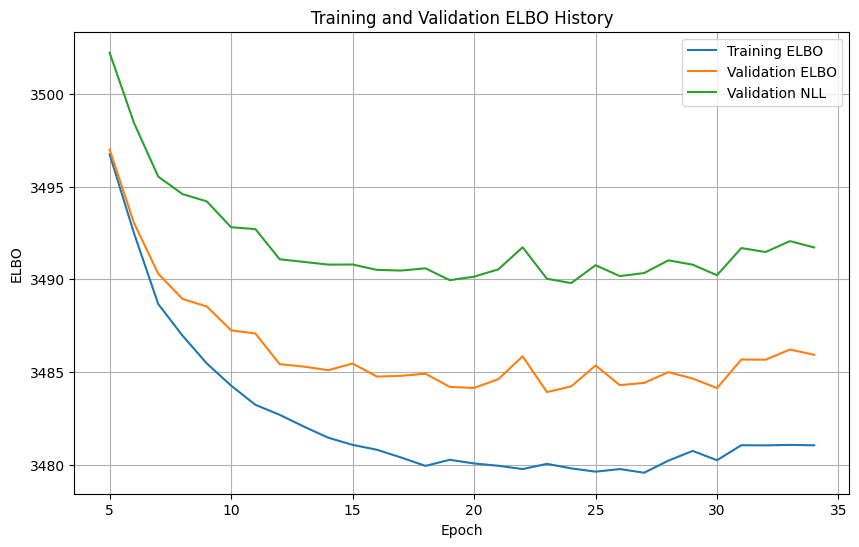

In [7]:
# Plot training and validation ELBO history
plt.figure(figsize=(10, 6))
plt.plot(model.history_["elbo_train"][5:], label="Training ELBO")
plt.plot(model.history_["elbo_validation"][5:], label="Validation ELBO")
plt.plot(model.history_["nll_validation"][5:], label="Validation NLL")
plt.xlabel("Epoch")
plt.ylabel("ELBO")
plt.title("Training and Validation ELBO History")
plt.legend()
plt.grid(True)
plt.show()

## Visualize the latent representation

Now that we have confirmed the model has converged, we can visualize the latent representation.

Notably, Decipher has two latent representations: `v` and `z`. `v` is a 2-dimensional latent representation which is amenable to direct visualization, while `z` is a higher-dimensional latent representation which is designed to capture more refined cell state information such as transitional intermediates.

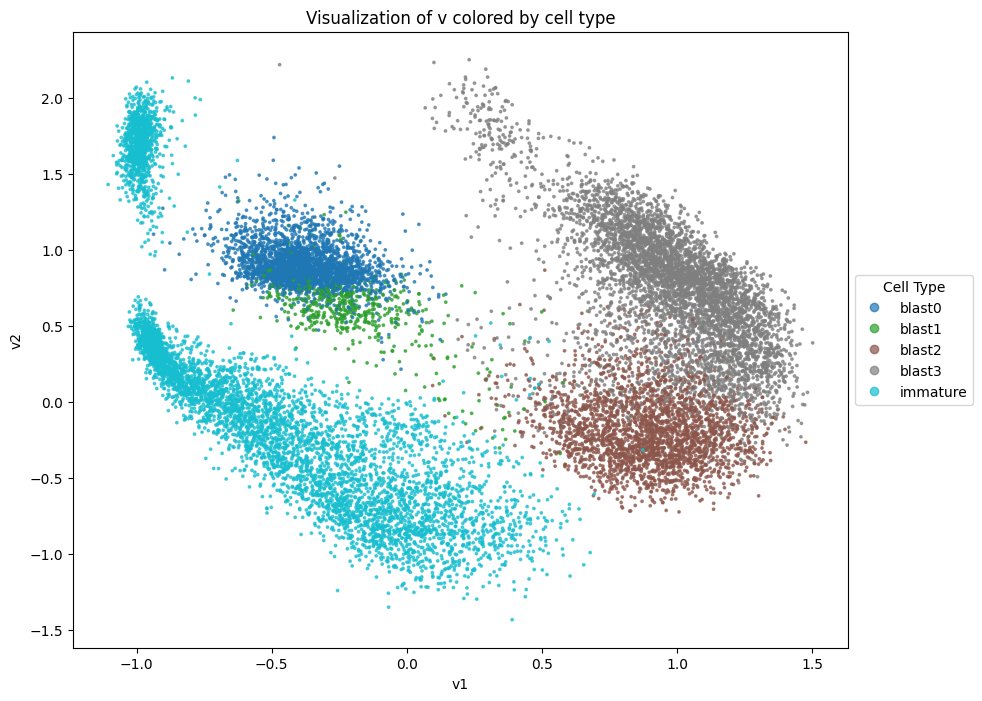

In [8]:
v = model.get_latent_representation()
# Plot v and color by cell type
cell_type_mapping = adata.obs["cell_type"].astype("category").cat
plt.figure(figsize=(10, 8))
scatter = plt.scatter(v[:, 0], v[:, 1], c=cell_type_mapping.codes, cmap="tab10", alpha=0.7, s=3)

plt.legend(
    scatter.legend_elements()[0],
    cell_type_mapping.categories,
    title="Cell Type",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

plt.title("Visualization of v colored by cell type")
plt.xlabel("v1")
plt.ylabel("v2")
plt.show()

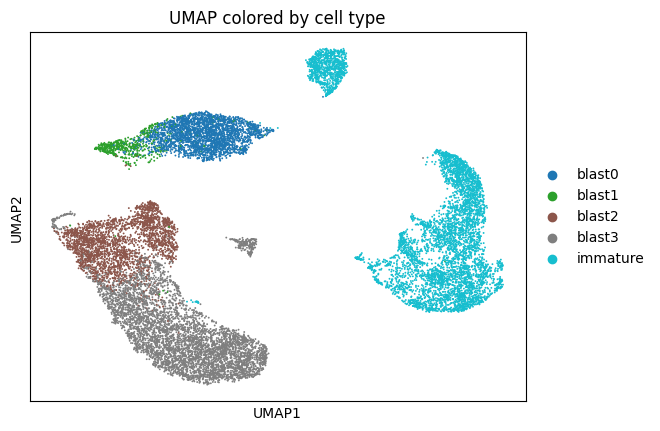

In [15]:
z = model.get_latent_representation(give_z=True)
adata.obsm["z"] = z
sc.pp.neighbors(adata, use_rep="z")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=True,
    palette="tab10",
    ncols=1,
    title="UMAP colored by cell type",
)